## Deep Q-Networks in Adaptive k-space Sampling for Precision MRI

### Abstract

This is a code for our paper "Deep Q-Networks in Adaptive k-space Sampling for Precision MRI" which presents a novel Deep Reinforcement Learning approach for optimizing k-space vertical line selection in undersampled Magnetic Resonance Imaging (MRI). By training a Deep Q-Network (DQN) agent to directly learn a sampling policy from reconstruction quality feedback (PSNR and SSIM), we demonstrate its ability to discover strategies superior to common heuristics, especially in high uncertainty regimes.

Experimental results demonstrate significant quantitative gains, suggesting that actively tailoring sampling patterns to specific image content and the reconstruction process through RL can substantially improve accelerated MRI performance within a fixed acquisition budget.

This work highlights the potential of reinforcement learning for precise image reconstruction within the MRI workflow, opening promising avenues for further improvement of clinical MRI technologies.


### Import Required Libraries

Import the required libraries (in some env these steps may not be needed)

In [ ]:
!pip install scikit-image

In [ ]:
import os
import h5py
import numpy as np
import random
from glob import glob
from functools import partial
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from collections import deque, namedtuple
import copy
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, ifftshift, fftn, ifftn

## Loading external dependencies

We are using some classes from FastMRI project, in particular `RandomMaskFunc`, `EquispacedMaskFractionFunc` which are used to generate baseline masks

https://github.com/facebookresearch/fastMRI/blob/main/fastmri/data/subsample.py

In [ ]:
!wget  https://github.com/facebookresearch/fastMRI/raw/main/fastmri/data/subsample.py

--2025-04-04 01:30:03--  https://github.com/facebookresearch/fastMRI/raw/main/fastmri/data/subsample.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/facebookresearch/fastMRI/main/fastmri/data/subsample.py [following]
--2025-04-04 01:30:04--  https://raw.githubusercontent.com/facebookresearch/fastMRI/main/fastmri/data/subsample.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 18509 (18K) [text/plain]
Saving to: ‘subsample.py’

subsample.py        100%[===================>]  18.08K  --.-KB/s    in 0.001s  

2025-04-04 01:30:04 (15.6 MB/s) - ‘subsample.py’ saved [18509/18509]



In [ ]:
from subsample import RandomMaskFunc, EquispacedMaskFractionFunc

def generate_ref_masks():
    rnd_mask_func_16 = RandomMaskFunc(center_fractions=[0.02], accelerations=[16])
    np.save('rnd_af16_cf0.02_pe320.npy', rnd_mask_func_16((1,320,1))[0].squeeze(dim=2)[0].float().numpy())
    rnd_mask_func_8 = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])
    np.save('rnd_af8_cf0.04_pe320.npy', rnd_mask_func_8((1,320,1))[0].squeeze(dim=2)[0].float().numpy())
    reg_mask_func_16 = EquispacedMaskFractionFunc(center_fractions=[0.02], accelerations=[16])
    np.save('reg_af16_cf0.02_pe320.npy', reg_mask_func_16((1,320,1))[0].squeeze(dim=2)[0].float().numpy())
    reg_mask_func_8 = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[8])
    np.save('reg_af8_cf0.04_pe320.npy', reg_mask_func_8((1,320,1))[0].squeeze(dim=2)[0].float().numpy())

In [ ]:
generate_ref_masks()

Baseline masks will be saved in files

```
reg_af8_cf0.04_pe320.npy
reg_af16_cf0.02_pe320.npy
rnd_af8_cf0.04_pe320.npy
rnd_af16_cf0.02_pe320.npy
```

### Setup Random Seed

We'll set a random seed for reproducibility.

In [ ]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


### Setup Device

We'll check if a GPU is available and set the device accordingly.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Some Utility Functions

Let's define some utility functions that we'll use throughout the tutorial.

In [ ]:
# Create directory
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


## Getting data

Note: for this project we assume the data is already downloaded and unpacked.

We do *not* include these steps, since the data archive is large (12.3GB)

For our experiments we use roughly 1/8 of the original number of files in each folder (about 2.3GB)

Total number of files in our tests:

Train: 1000

Validation: 500


The code expects the following folder structure:

```
fastmri_pd/train/h5/file1000003_000.h5
(1000 files)
...
fastmri_pd/val/h5/file1000031_000.h5
(500 files)
...
```   



The data can be retrieved in the following way:

NOTE: this is only in scope of I-X project, the original dataset can be downloaded from https://fastmri.med.nyu.edu/

```
sudo apt install megatools
megadl 'https://mega.nz/#!40FEHA4I!dVSEdQ6dGcEY3Pf9PHhFjCNzlmIt6rjzlkB6gyDW4ns'
ls -sha
tar -xf fastmri_pd.tar.gz
```

In [ ]:
data_path = './fastmri_pd'

## Load and Visualize a Sample

MRI data is loaded in .h5 format, containing complex-valued images. Magnitude and phase components are extracted for visualization. The magnitude and phase images reveal important structural and phase information, offering insights into the data quality and characteristics.


In [ ]:
# Load H5 file
def read_processed_h5(data_path):
    with h5py.File(data_path, 'r') as file:
        data = {
            'image_complex': file['image_complex'][()],
            'data_name': file['image_complex'].attrs['data_name'],
            'slice_idx': file['image_complex'].attrs['slice_idx'],
        }
    return data

In [ ]:
## !tar -xf data.tar.gz

#### Normalisation Function

We are using normalisation based on the magnitude component.


In [ ]:
# Normalisation
def preprocess_normalisation(img, type):
    if type == 'complex_mag':
        # Calculate magnitude
        magnitude = np.abs(img)

        # Normalize to [0, 1]
        min_mag = np.min(magnitude)
        max_mag = np.max(magnitude)

        # Avoid division by zero if the image has uniform intensity
        if max_mag - min_mag == 0:
            img = np.zeros_like(img, dtype=np.float64) # set image to all zeros
        else:
            img = (img - min_mag) / (max_mag - min_mag)
    else:
        raise NotImplementedError

    return img

In [ ]:
# Load H5 data
sample_data = read_processed_h5(f'{data_path}/val/h5/file1000031_010.h5')
#sample_data = read_processed_h5(f'{data_path}/dataset/train/file1000005_000.h5')

# Load complex MR data
image_complex = sample_data['image_complex']

# Do normalisation
image_complex_norm = preprocess_normalisation(image_complex, type='complex_mag')

# Show some information before and after normalisation
min_vefore = np.min(image_complex)
max_vefore = np.max(image_complex)
min_vafter = np.min(image_complex_norm)
max_vafter = np.max(image_complex_norm)
print(f"Data Shape: {image_complex.shape}; Data Type: {image_complex.dtype};")
print(f"Data Range (before normalisation): {min_vefore}~{max_vefore};")
print(f"Data Range (after normalisation): {min_vafter}~{max_vafter}")


Data Shape: (320, 320); Data Type: complex64;
Data Range (before normalisation): (-9.499424180603455e-08-2.1092693813784535e-08j)~(3.8276937175396597e-07+7.818297120820716e-08j);
Data Range (after normalisation): (-0.24395321309566498-0.054025374352931976j)~(0.9797576665878296+0.2002524882555008j)


In [ ]:
# Extract components: magnitude and phase
image_magnitude = np.abs(image_complex_norm)
image_phase = np.angle(image_complex_norm)
min_pahse = np.min(image_phase)
max_phase = np.max(image_phase)
print(f"Data Range (phase): {min_pahse}~{max_phase}")

Data Range (phase): -3.141395092010498~3.141570568084717


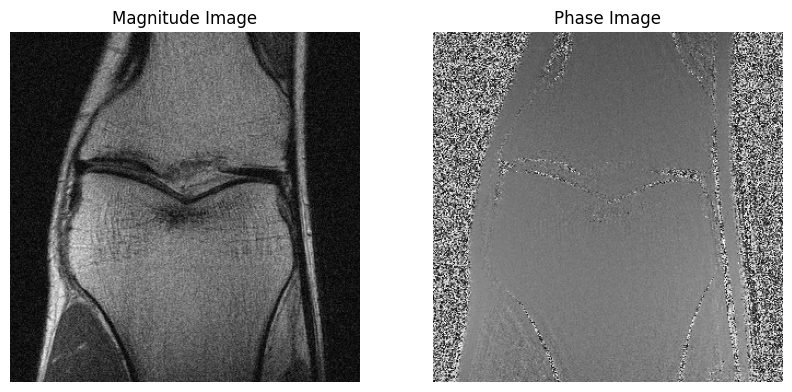

In [ ]:

# Plot the images
plt.figure(figsize=(10, 10))
# Magnitude image
plt.subplot(2, 2, 1)
plt.imshow(image_magnitude, cmap='grey')
plt.title('Magnitude Image')
plt.axis('off')
# Phase image
plt.subplot(2, 2, 2)
plt.imshow(image_phase, cmap='grey')
plt.title('Phase Image')
plt.axis('off')
plt.show()


### K-space Undersampling Pattern

Undersampling masks, such as GRAPPA-like or random Gaussian, are loaded. These masks define the specific sampling patterns applied to k-space data, simulating accelerated acquisition.



Why Undersampling? MRI scans are notoriously slow. Undersampling k-space means acquiring fewer data points than would be needed to fully fill the k-space matrix (320x320 in this case). This directly reduces scan time.

How is it Done? Undersampling is typically achieved by skipping certain lines or regions in k-space during data acquisition. There are various undersampling patterns:
        
* Cartesian Undersampling: Regularly skipping lines in k-space. This is simple to implement but can introduce aliasing artifacts if not done carefully.
* Radial Undersampling: Acquiring data along radial lines emanating from the center of k-space. This can be less susceptible to aliasing than Cartesian undersampling.
* Spiral Undersampling: Acquiring data along spiral trajectories.

The Trade-off: Aliasing is the main problem with undersampling is that it violates the Nyquist-Shannon sampling theorem, which states that to accurately reconstruct a signal, the sampling rate must be at least twice the highest frequency present in the signal. When undersampling, high-frequency components can be misinterpreted as lower-frequency components, leading to aliasing artifacts in the reconstructed image. These artifacts can appear as ghosting, blurring, or other distortions.



In [ ]:
Mask = namedtuple('Mask', ('data', 'name', 'lines', 'size'))

# Undersampling mask selection
def define_mask(dir_name, mask_name):

    # GRAPPA-like (with ACS) Regular Acceleration Factor x Central Fraction x PE (from fastMRI)
    if mask_name == 'fMRI_Reg_AF8_CF0.04_PE320':
        mask_1d = np.load(os.path.join(dir_name, 'reg_af8_cf0.04_pe320.npy'))
    elif mask_name == 'fMRI_Reg_AF16_CF0.02_PE320':
        mask_1d = np.load(os.path.join(dir_name, 'reg_af16_cf0.02_pe320.npy'))

    # GRAPPA-like (with ACS) Random (Gaussian) Acceleration Factor x Central Fraction x PE (from fastMRI)
    elif mask_name == 'fMRI_Ran_AF8_CF0.04_PE320':
        mask_1d = np.load(os.path.join(dir_name, 'rnd_af8_cf0.04_pe320.npy'))
    elif mask_name == 'fMRI_Ran_AF16_CF0.02_PE320':
        mask_1d = np.load(os.path.join(dir_name, 'rnd_af16_cf0.02_pe320.npy'))

    else:
        mask_1d = np.load(os.path.join(dir_name, f'{mask_name}.npy'))

    print(type(mask_1d[0]))
    mask_1d = mask_1d[:, np.newaxis]
    mask = np.repeat(mask_1d, 320, axis=1).transpose((1, 0))
    lines = int(np.sum(mask[0,:])) # Count non-zero lines.  Since the mask is repeated, we can sum the first row.
    size = mask.shape[1]

    return Mask(data=mask, name=mask_name, lines=lines, size=size)

In [ ]:
def visualize_mask(mask):
    plt.figure(figsize=(14, 4))

    plt.imshow(mask.data, cmap='gray')
    plt.title(f'K-Space Undersampling Mask - {mask.name}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

<class 'numpy.float32'>
20 320


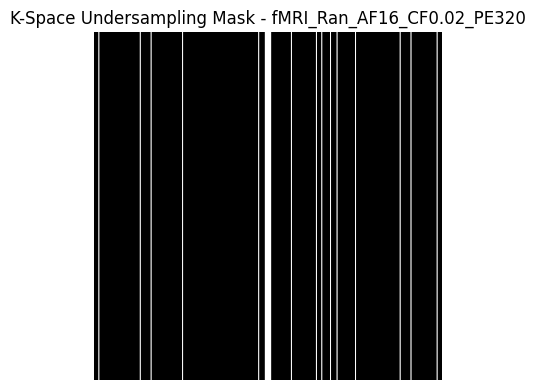

In [ ]:
rnd_sample_mask = define_mask(dir_name='./', mask_name='fMRI_Ran_AF16_CF0.02_PE320')
print(rnd_sample_mask.lines, rnd_sample_mask.size)
visualize_mask(rnd_sample_mask)


<class 'numpy.float32'>
20 320


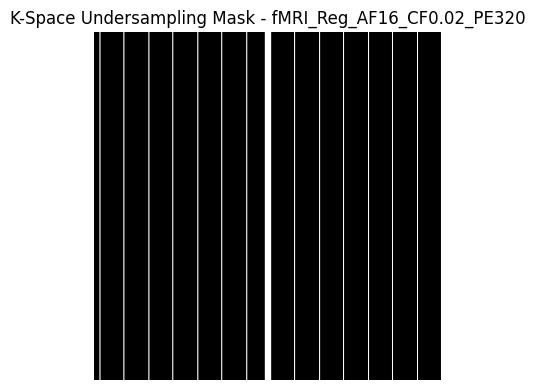

In [ ]:
reg_sample_mask = define_mask(dir_name='./', mask_name='fMRI_Reg_AF16_CF0.02_PE320')
print(reg_sample_mask.lines, reg_sample_mask.size)
visualize_mask(reg_sample_mask)

### K-space Undersampling

The undersampling mask is applied to the fully sampled k-space data. This step simulates accelerated MRI acquisition, introducing aliasing artifacts. An inverse FFT reconstructs the image from undersampled k-space data, revealing the extent of artifacts caused by undersampling.


### Image reconstruction

The goal of image reconstruction is to create a high-quality image from the incomplete (undersampled) k-space data. This involves mitigating or removing the aliasing artifacts introduced by undersampling.

Methods: Several methods are used for image reconstruction from undersampled k-space data:

* Zero-Filling: The simplest approach is to fill in the missing k-space data points with zeros. While this allows you to perform an inverse Fourier Transform to get an image, it results in significant aliasing artifacts. It essentially acts as a basic interpolation.

* Parallel Imaging (e.g., SENSE, GRAPPA): These techniques use data from multiple receiver coils to estimate the missing k-space data. Each coil has a slightly different sensitivity profile, providing complementary information about the object. SENSE uses a coil sensitivity map to unfold the aliased image, while GRAPPA learns the relationship between missing and acquired k-space data directly from the data itself.

* Compressed Sensing: This is a more advanced technique that exploits the fact that many images are sparse in some transform domain (e.g., wavelet transform). It formulates the image reconstruction problem as an optimization problem that seeks to find the sparsest image that is consistent with the acquired k-space data. This requires iterative reconstruction algorithms.
        
Compressed sensing relies on two key properties:
* Sparsity: The image can be represented with only a few non-zero coefficients in a particular transform domain (e.g., wavelet transform).
* Incoherence: The sampling pattern in k-space is incoherent with the sparsifying transform. This means that the aliasing artifacts introduced by undersampling are spread out randomly across the image, rather than being concentrated in specific areas.


Final Image: After reconstruction, we'll have a 320x320 image of the knee. This image will hopefully be free of significant aliasing artifacts and will show the anatomy of the knee (bones, ligaments, cartilage, muscles) with good contrast and resolution.


## Deep Reinforcement Learning (DRL) approach to calculate the optimal mask

### Introducing some helper functions and quick EDA

In [ ]:
from PIL import Image
import scipy.fftpack

def apply_mask(x, mask):

    fft_before = fftshift(
        fftn(
            ifftshift(x, axes=(-2, -1))
        )
    )
    fft = fft_before * mask.data
    x = fftshift(ifftn(ifftshift(fft, axes=(-2, -1))), axes=(-2, -1))


    img_reconstructed = np.abs(x)  # Take the absolute value
    fft, fft_before = np.abs(fft), np.abs(fft_before)
    fft = np.clip(fft, 0, np.percentile(fft, 95.0))
    fft_before = np.clip(fft_before, 0, np.percentile(fft_before, 95.0))
    #print(fft)

    return img_reconstructed, fft, fft_before

def visualize_masked_image(image, mask):

     reconstructed_img_mask1, ft, ft_before = apply_mask(image, mask)
     psnr_1 = psnr(image, reconstructed_img_mask1, data_range=image.max() - image.min())
     ssim_1 = ssim(image, reconstructed_img_mask1, data_range=image.max() - image.min())
     print(psnr_1, ssim_1)

     plt.figure(figsize=(12, 4))

     plt.subplot(1, 3, 1)
     plt.imshow(image, cmap='gray')
     plt.title('Original Image')

     plt.subplot(1, 3, 2)
     plt.imshow(reconstructed_img_mask1, cmap='gray')
     plt.title(f'Reconstructed\n{mask.name}\n PSNR: {psnr_1:.4f}, SSIM: {ssim_1:.4f}')

     plt.subplot(1, 3, 3)
     plt.imshow(ft, cmap='jet')
     plt.title('k-space + mask')

     plt.tight_layout()
     plt.show()

In [ ]:
print(image_magnitude)
print(reg_sample_mask)

[[0.08304585 0.01169755 0.06849733 ... 0.09049823 0.12509227 0.08548041]
 [0.07665604 0.07261614 0.07428427 ... 0.08195394 0.05793746 0.05103091]
 [0.07258219 0.14189    0.01131506 ... 0.00787599 0.06584662 0.0917301 ]
 ...
 [0.07786672 0.12769759 0.17405649 ... 0.02830251 0.10977726 0.11285365]
 [0.07314838 0.05011895 0.06128524 ... 0.05585995 0.05785926 0.08148818]
 [0.06364482 0.15827118 0.07737962 ... 0.08775867 0.01681009 0.13876311]]
Mask(data=array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), name='fMRI_Reg_AF16_CF0.02_PE320', lines=20, size=320)


19.368270472897734 0.2885271419095052


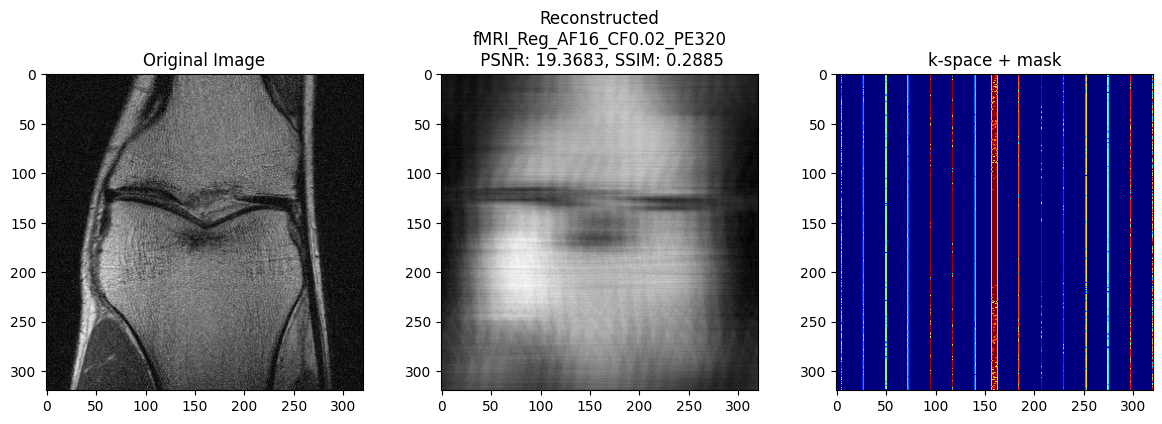

In [ ]:
visualize_masked_image(image_magnitude, reg_sample_mask)


### Define DQN model

In [ ]:
import random
import time
import os
import copy # For deep copying target network

# Image-related constants
IMG_SIZE = 320
N_LINES_TOTAL = IMG_SIZE # Total vertical lines available
BUDGET_N = 20            # Max number of lines to select in total
INITIAL_K = 4            # Number of central lines in the initial mask (must be even)

# DQN Parameters
BUFFER_SIZE = 10000     # Replay buffer size
BATCH_SIZE = 32         # Minibatch size for training
GAMMA = 0.95            # Discount factor
EPS_START = 1.0         # Starting epsilon for exploration
EPS_END = 0.01          # Minimum epsilon
EPS_DECAY = 0.995       # Epsilon decay rate per episode
LR = 1e-3               # Learning rate for Adam optimizer
TARGET_UPDATE_FREQ = 10 # How often to update the target network (episodes)
N_EPISODES = 100         # Total training episodes
REWARD_SCALING = 1.0    # Optional scaling for reward values

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure INITIAL_K is even and less than BUDGET_N
assert INITIAL_K % 2 == 0, "INITIAL_K must be even"
assert INITIAL_K < BUDGET_N, "INITIAL_K must be less than BUDGET_N"
assert BUDGET_N <= N_LINES_TOTAL, "BUDGET_N cannot exceed N_LINES_TOTAL"

Using device: cpu


### Define helper functions to move data between k-space and image space

In [ ]:
def image_to_kspace(img):
    """Converts an image space image to k-space using 2D FFT."""
    # Ensure input is numpy array
    img = np.array(img)
    # Apply iFFTshift before FFT, then FFTshift after
    kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    return kspace

def kspace_to_image(kspace):
    """Converts k-space data back to image space using inverse 2D FFT."""
    # Ensure input is numpy array
    kspace = np.array(kspace)
    # Apply iFFTshift before iFFT, then FFTshift after
    img_complex = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace)))
    # Return magnitude
    return np.abs(img_complex)

def apply_mask_and_reconstruct(full_kspace, mask):
    """Applies a mask to k-space and reconstructs the image."""
    undersampled_kspace = full_kspace * mask
    reconstructed_image = kspace_to_image(undersampled_kspace)
    return reconstructed_image

def create_initial_mask(shape, k):
    """Creates a mask with the central k vertical lines."""
    if k > shape[1]:
        raise ValueError("k cannot be larger than the number of columns")
    if k % 2 != 0:
        raise ValueError("k (number of central lines) must be even")

    mask = np.zeros(shape, dtype=bool)
    center_col = shape[1] // 2
    start_col = center_col - k // 2
    end_col = center_col + k // 2 + 1 # last index is exclusive!
    mask[:, start_col:end_col] = True
    return mask

def add_line_to_mask(mask, col_index):
    """Adds a vertical line at the specified index to the mask."""
    if col_index < 0 or col_index >= mask.shape[1]:
        raise IndexError("col_index out of bounds")
    new_mask = mask.copy()
    new_mask[:, col_index] = True
    return new_mask

def calculate_metrics(img_true, img_recon):
    """Calculates PSNR and SSIM between true and reconstructed images."""
    # Ensure images are in [0, 1] range if needed, or specify data_range
    # Note: assuming input images are already appropriately scaled!!
    data_range = np.max(img_true) - np.min(img_true)
    if data_range == 0: # constant image case
        psnr_val = np.inf if np.allclose(img_true, img_recon) else 0.0
        ssim_val = 1.0 if np.allclose(img_true, img_recon) else 0.0
    else:
        # Clip reconstructed image to true image range for stability
        img_recon_clipped = np.clip(img_recon, np.min(img_true), np.max(img_true))

        psnr_val = psnr(img_true, img_recon_clipped, data_range=data_range)
        # For SSIM, ensure Winnining_API is True for newer skimage versions or remove if not available
        # Or explicitly set win_size if needed and known, must be odd and <= min(img_dim)
        win_size = min(7, img_true.shape[0], img_true.shape[1])
        if win_size % 2 == 0: win_size -= 1 # Ensure odd
        ssim_val = ssim(img_true, img_recon_clipped, data_range=data_range, win_size=win_size, channel_axis=None) # Use channel_axis=None for grayscale

    return psnr_val, ssim_val

# macro to decrease boilercode
to_tensor = lambda im: torch.tensor(im, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

### Define Q-Network, environment and RL Agent

In [ ]:
# describe 1 transition, with boolean flag done=True if the state is terminal
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# Experience Replay Buffer

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Q-Network (using a simple CNN)
# NOTE: we have hardcoded NN params, so it works only with tensor of shape (1,320)!!
class DQN(nn.Module):
    def __init__(self, input_channels=1, num_actions=320):  # Assuming W=320 in mask
        super(DQN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=4, stride=4)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=2, stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2496, 512)  # calc based on conv output
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        #print(f"Q in: {x.shape}")
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Main RL class

class DQNAgent:

    def __init__(self, img_h, img_w, n_actions, buffer_size, batch_size, gamma, lr, target_update_freq, eps_start, eps_end, eps_decay):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.epsilon = eps_start

        self.policy_net = DQN(1, n_actions).to(device)
        self.target_net = DQN(1, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # Target network is only for inference

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, weight_decay=0.9995, amsgrad=True)
        self.memory = ReplayBuffer(buffer_size)

        self.steps_done = 0
        self.episodes_done = 0
        self.tau = 5e-4

        self.stat = np.zeros(320, dtype=int)

    def select_action(self, state_img, available_actions_mask):
        action_mask = torch.full((1, self.n_actions), -float('inf'), device=device)
        for idx in available_actions_mask:
            action_mask[0, idx] = 0.0 # Allows selection by adding 0

        if random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = to_tensor(state_img)
                q_values = self.policy_net(state_tensor)
                # Apply mask: Add mask (-inf for invalid, 0 for valid) before argmax
                masked_q_values = q_values + action_mask
                # Select the best action among the *available* ones
                action = masked_q_values.max(1)[1].view(1, 1) # choose INDEX of the MAX value!
        else:
             # Ensure we only choose from available actions
             valid_indices = torch.where(action_mask > -float('inf'))[1] # Get indices where value is 0
             action = torch.tensor([[random.choice(valid_indices.tolist())]], device=device, dtype=torch.long)

        self.steps_done += 1
        idx = action.item()
        self.stat[idx] += 1
        return idx # Return index

    def learn(self):
        if len(self.memory) < self.batch_size:
            return None # Not enough memory yet

        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch - converts (a1, b1), (a2, b2) -> (a1, a2), (b1, b2) , etc
        batch = Transition(*zip(*transitions))

        # Filter out non-final states for next_state calculation
        # using  (list of boolean "done" flags) and (and list of next states)
        non_final_filter = torch.tensor(tuple(map(lambda d: not d, batch.done)), device=device, dtype=torch.bool)
        non_final_next_states_list = [s for s, d in zip(batch.next_state, batch.done) if not d]

        # forming a batch
        state_batch_list = [to_tensor(s_img) for s_img in batch.state]
        state_batch = torch.cat(state_batch_list, dim=0) # Shape: (batch_size, 1, W) cuz we have 1 channel and B images in batch

        # Concatenate non-final next states only if they exist
        if non_final_next_states_list:
            non_final_next_states_li = [to_tensor(ns_img) for ns_img in non_final_next_states_list]
            non_final_next_states = torch.cat(non_final_next_states_li, dim=0)
        else:
            # Create an empty tensor with the correct shape if there are no non-final states in the batch
            # Shape should be (0, 1, W)
            img_w = state_batch.shape[2]
            non_final_next_states = torch.empty((0, 1, img_w), device=device)

        # NOTE: action is an index, ie. integer value which points to some elem in 320-vector
        # so action_batch is a row of indecies
        action_batch = torch.tensor(batch.action, device=device, dtype=torch.long).unsqueeze(1) # Shape: (batch_size, 1)
        reward_batch = torch.tensor(batch.reward, device=device, dtype=torch.float32) # Shape: (batch_size,)

        ####### ALL DATA IS IN BATCHES NOW  ########

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
        # using action_batch as a filter to choose which element of 128 to pick up
        state_action_values = self.policy_net(state_batch).gather(1, action_batch) # Shape: (batch_size, 1)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        next_state_values = torch.zeros(self.batch_size, device=device)
        if non_final_next_states.numel() > 0:
            with torch.no_grad():
                next_state_values[non_final_filter] = self.target_net(non_final_next_states).max(1)[0]

        # Compute the expected Q values (Bellman equation)
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        expected_state_action_values = expected_state_action_values.unsqueeze(1)

        # Compute Huber loss
        # In general, it should be L1-like loss
        criterion = nn.HuberLoss()
        loss = criterion(state_action_values, expected_state_action_values) # Target needs shape (batch_size, 1)

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping for stability - avoid exp gradients
        # NOTE: it could hurt stability in some versions of torch
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.item()


    def update_target_net(self):
        """Update the target network by copying weights from the policy network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def sync_nets(self):
        """ Soft merging """
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()

        for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)

        self.target_net.load_state_dict(target_net_state_dict)


    def decay_epsilon(self):
        self.epsilon = max(self.eps_end, self.eps_decay * self.epsilon)

    def end_episode(self):
        self.decay_epsilon()
        self.episodes_done += 1
        if self.episodes_done % self.target_update_freq == 0:
            self.sync_nets()

    def save_model(self, path="dqn_mri_model.pth"):
        torch.save(self.policy_net.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path="dqn_mri_model.pth"):
        if os.path.exists(path):
            self.policy_net.load_state_dict(torch.load(path, map_location=device))
            self.target_net.load_state_dict(self.policy_net.state_dict()) # Sync target net too
            self.policy_net.eval() # Set to evaluation mode if loaded for inference
            self.target_net.eval()
            print(f"Model loaded from {path}")
        else:
            print(f"Warning: Model file not found at {path}")

# --- Training Setup ---



In [ ]:
## sanity test
input_channels = 1
num_actions = 320 # Example number of actions
model = DQN(input_channels=input_channels, num_actions=num_actions)
dummy = torch.randn((64, input_channels, 320)) # (B, 1, 320)
model(dummy).shape

torch.Size([64, 320])

In [ ]:
def train(ground_truth_image, agent, name="train"):
    print(f"image shape: {ground_truth_image.shape}, dtype: {ground_truth_image.dtype}, range: [{ground_truth_image.min()}, {ground_truth_image.max()}]")

    full_kspace = image_to_kspace(ground_truth_image)

    episode_rewards = []
    episode_final_psnr = []
    episode_final_ssim = []
    episode_losses = [] # Track average loss per episode
    best_mask_overall = None
    best_psnr_overall = -np.inf

    print(f"\n--- Starting Training for {N_EPISODES} episodes ---")
    print(f"Budget N={BUDGET_N}, Initial K={INITIAL_K}")
    print(f"Reward based on: SSIM + PSNR improvement (Scaled by {REWARD_SCALING})")

    start_time_total = time.time()

    with tqdm(total=N_EPISODES, desc=f"Training") as pbar:
      for i_episode in range(N_EPISODES):
          episode_start_time = time.time()
          current_mask = create_initial_mask((IMG_SIZE, IMG_SIZE), INITIAL_K)
          selected_lines = set(range(IMG_SIZE // 2 - INITIAL_K // 2, IMG_SIZE // 2 + INITIAL_K // 2))
          assert len(selected_lines) == INITIAL_K
          num_lines_selected = INITIAL_K
          total_episode_reward = 0
          losses_in_episode = []

          # Initial state reconstruction
          current_reconstruction = apply_mask_and_reconstruct(full_kspace, current_mask)
          state = current_mask[0] # Use reconstruction as state
          psnr_prev, ssim_prev = calculate_metrics(ground_truth_image, current_reconstruction)

          max_steps_per_episode = BUDGET_N - INITIAL_K

          for step in range(max_steps_per_episode):
              # Determine available actions (lines not yet selected)
              available_actions = [idx for idx in range(N_LINES_TOTAL) if idx not in selected_lines]

              # Agent selects action (index of the line to add)
              action_idx = agent.select_action(state, available_actions)

              # Execute action: Add the chosen line to the mask
              next_mask = add_line_to_mask(current_mask, action_idx)
              selected_lines.add(action_idx)
              num_lines_selected += 1

              # Get next state (new reconstruction)
              next_reconstruction = apply_mask_and_reconstruct(full_kspace, next_mask)
              next_state = next_mask[0]

              psnr_new, ssim_new = calculate_metrics(ground_truth_image, next_reconstruction)

              reward = (ssim_new - ssim_prev) * REWARD_SCALING + (psnr_new - psnr_prev) * REWARD_SCALING

              total_episode_reward += reward
              psnr_prev, ssim_prev = psnr_new, ssim_new

              # Determine if episode is done (reached budget N)
              done = (num_lines_selected >= BUDGET_N)

              # Store transition in replay memory
              agent.memory.push(state, action_idx, next_state, reward, done)

              # Move to the next state
              state = next_state
              current_mask = next_mask

              loss = agent.learn()
              if loss is not None:
                  losses_in_episode.append(loss)

              if done:
                  break

          # --- End of Episode ---
          agent.end_episode() # Decay epsilon, potentially update target net

          episode_rewards.append(total_episode_reward)
          episode_final_psnr.append(psnr_new)
          episode_final_ssim.append(ssim_new)
          episode_loss_avg = np.mean(losses_in_episode) if losses_in_episode else 0
          episode_losses.append(episode_loss_avg)

          # Track the best mask found so far based on final PSNR
          if psnr_new > best_psnr_overall:
              best_psnr_overall = psnr_new
              best_mask_overall = current_mask # Save the mask that achieved this PSNR

          pbar.set_postfix({"psnr":psnr_new, "ssim": ssim_new, "loss": episode_loss_avg, "best_psnr": best_psnr_overall})
          pbar.update(1)



    total_duration = time.time() - start_time_total
    print(f"\n--- Training Finished in {total_duration:.2f} seconds ---")
    print(f"Best PSNR achieved during training: {best_psnr_overall:.4f}")

    # Save the trained model
    agent.save_model()
    mask_name = f"best_mask_{name}"
    np.save(mask_name, best_mask_overall[0].astype(np.float32))  # Explicitly cast to float32 for consistency

    # Return training history and the best mask found
    history = {
        'rewards': episode_rewards,
        'psnr': episode_final_psnr,
        'ssim': episode_final_ssim,
        'loss': episode_losses
    }
    return history, best_mask_overall, ground_truth_image, full_kspace

In [ ]:
def test_agent(agent, ground_truth_image, full_kspace, name="test"):
    """Uses the trained agent (in eval mode with epsilon=0) to find the best mask "greedily"."""
    print("\n--- Testing trained agent (greedy policy) ---")
    agent.policy_net.eval() # Set to evaluation mode
    agent.epsilon = 0 # No exploration

    current_mask = create_initial_mask((IMG_SIZE, IMG_SIZE), INITIAL_K)
    selected_lines = set(range(IMG_SIZE // 2 - INITIAL_K // 2, IMG_SIZE // 2 + INITIAL_K // 2))
    assert len(selected_lines) == INITIAL_K
    num_lines_selected = INITIAL_K

    initial_reconstruction = apply_mask_and_reconstruct(full_kspace, current_mask)
    state = current_mask[0]
    psnr_start, ssim_start = calculate_metrics(ground_truth_image, initial_reconstruction)
    print(f"Initial ({INITIAL_K} lines) PSNR: {psnr_start:.4f}, SSIM: {ssim_start:.4f}")


    trajectory_psnr = [psnr_start]
    trajectory_ssim = [ssim_start]
    trajectory_masks = [current_mask.copy()]
    trajectory_recons = [initial_reconstruction.copy()]
    selected_line_indices = list(selected_lines) # Track order

    max_steps = BUDGET_N - INITIAL_K
    for step in range(max_steps):
        available_actions = [idx for idx in range(N_LINES_TOTAL) if idx not in selected_lines]
        if not available_actions:
            break

        action_idx = agent.select_action(state, available_actions) # Will be greedy due to epsilon=0

        # Ensure selected action is valid (should be, but safety check)
        if action_idx not in available_actions:
             print(f"Error during testing: Agent chose invalid action {action_idx}. Available: {available_actions}.")
             break # Stop if something goes wrong

        # Execute action
        next_mask = add_line_to_mask(current_mask, action_idx)
        selected_lines.add(action_idx)
        selected_line_indices.append(action_idx)
        num_lines_selected += 1

        next_reconstruction = apply_mask_and_reconstruct(full_kspace, next_mask)
        next_state = next_mask[0]

        psnr_new, ssim_new = calculate_metrics(ground_truth_image, next_reconstruction)

        # Update state and mask
        state = next_state
        current_mask = next_mask

        # Store trajectory info
        trajectory_psnr.append(psnr_new)
        trajectory_ssim.append(ssim_new)
        trajectory_masks.append(current_mask.copy())
        trajectory_recons.append(next_reconstruction.copy())


    final_mask = current_mask
    final_reconstruction = next_reconstruction
    final_psnr, final_ssim = psnr_new, ssim_new # Last calculated metrics
    print(f"Final Mask ({num_lines_selected} lines) PSNR: {final_psnr:.4f}, SSIM: {final_ssim:.4f}")
    mask_name = f"best_mask_{name}"
    np.save(mask_name, final_mask[0].astype(np.float32))  # Explicitly cast to float32 for consistency

    test_results = {
        'final_mask': final_mask,
        'final_reconstruction': final_reconstruction,
        'final_psnr': final_psnr,
        'final_ssim': final_ssim,
        'initial_mask': trajectory_masks[0],
        'initial_reconstruction': trajectory_recons[0],
        'selected_lines_order': selected_line_indices,
        'psnr_trajectory': trajectory_psnr,
        'ssim_trajectory': trajectory_ssim,
    }
    return test_results

In [ ]:
def visualize_results_history(history, test_results, ground_truth_image, best_mask_from_training):
    """Visualizes training history and test results."""

    # Training History Plots
    fig_train, axs_train = plt.subplots(1, 2, figsize=(14, 6))
    fig_train.suptitle('Training History')

    axs_train[0].plot(history['rewards'])
    axs_train[0].set_title('Total Episode Rewards')
    axs_train[0].set_xlabel('Episode')
    axs_train[0].set_ylabel('Cumulative Reward')

    axs_train[1].plot(history['loss'])
    axs_train[1].set_title('Average Episode Loss')
    axs_train[1].set_xlabel('Episode')
    axs_train[1].set_ylabel('Avg Loss')

    plt.tight_layout() # Adjust layout to prevent title overlap
    plt.savefig("training_history.svg")
    plt.show()

def visualize_results_test_trajectories(history, test_results, ground_truth_image, best_mask_from_training):
    """Visualizes training history and test results."""

    # Test Trajectory Plots
    fig_traj, axs_traj = plt.subplots(1, 2, figsize=(14, 5))
    fig_traj.suptitle('Test Trajectory (Greedy Policy)')
    steps = range(len(test_results['psnr_trajectory'])) # Number of lines from K to N
    line_counts = [INITIAL_K + i for i in steps]

    axs_traj[0].plot(line_counts, test_results['psnr_trajectory'], marker='o')
    axs_traj[0].set_title('PSNR vs. Number of Lines')
    axs_traj[0].set_xlabel('Number of Lines Selected')
    axs_traj[0].set_ylabel('PSNR (dB)')
    axs_traj[0].grid(True)

    axs_traj[1].plot(line_counts, test_results['ssim_trajectory'], marker='o')
    axs_traj[1].set_title('SSIM vs. Number of Lines')
    axs_traj[1].set_xlabel('Number of Lines Selected')
    axs_traj[1].set_ylabel('SSIM')
    axs_traj[1].grid(True)

    plt.tight_layout()
    plt.savefig("test_trajectory.svg")
    plt.show()

def visual_check_1(history, test_results, ground_truth_image, best_mask_from_training):
    """Visualizes training history and test results."""
    fig_comp, axs_comp = plt.subplots(1, 3, figsize=(17, 6))
    fig_comp.suptitle(f'Comparison (Budget N={BUDGET_N})')

    im0 = axs_comp[0].imshow(ground_truth_image, cmap='gray')
    axs_comp[0].set_title('Ground Truth')
    axs_comp[0].axis('off')
    fig_comp.colorbar(im0, ax=axs_comp[0], fraction=0.034, pad=0.04)

    im1 = axs_comp[1].imshow(test_results['initial_reconstruction'], cmap='gray')
    axs_comp[1].set_title(f'Initial Recon ({INITIAL_K} lines)\nPSNR={test_results["psnr_trajectory"][0]:.2f}, SSIM={test_results["ssim_trajectory"][0]:.2f}')
    axs_comp[1].axis('off')
    fig_comp.colorbar(im1, ax=axs_comp[1], fraction=0.034, pad=0.04)

    im2 = axs_comp[2].imshow(test_results['final_reconstruction'], cmap='gray')
    axs_comp[2].set_title(f'Final Recon (Test, {len(test_results["selected_lines_order"])} lines)\nPSNR={test_results["final_psnr"]:.2f}, SSIM={test_results["final_ssim"]:.2f}')
    axs_comp[2].axis('off')
    fig_comp.colorbar(im2, ax=axs_comp[2], fraction=0.034, pad=0.04)

def visual_check_2(test_results, best_mask_from_training):
    fig_comp, axs_comp = plt.subplots(1, 3, figsize=(15, 4))
    fig_comp.suptitle(f'Comparison (Budget N={BUDGET_N})')
    axs_comp[0].imshow(test_results['initial_mask'], cmap='gray')
    axs_comp[0].set_title(f'Initial Mask ({INITIAL_K} lines)')
    axs_comp[0].axis('off')

    axs_comp[1].imshow(test_results['final_mask'], cmap='gray')
    axs_comp[1].set_title(f'Learned Mask (RL run)')
    axs_comp[1].axis('off')

    if best_mask_from_training is not None:
        axs_comp[2].imshow(best_mask_from_training, cmap='gray')
        axs_comp[2].set_title(f'Best Mask Found During Training')
        axs_comp[2].axis('off')


    plt.tight_layout()
    plt.savefig("image_mask_comparison.png")
    plt.show()



## Experiments

In [ ]:
def load_sample_image(im_path):
  data = read_processed_h5(im_path)
  image_complex = data['image_complex']
  image_complex_norm = preprocess_normalisation(image_complex, type='complex_mag')
  return np.abs(image_complex_norm)

In [ ]:
sample_image = load_sample_image(f'{data_path}/val/h5/file1000031_010.h5')
# Initialize Agent
agent = DQNAgent(
    img_h=IMG_SIZE,
    img_w=IMG_SIZE,
    n_actions=N_LINES_TOTAL,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    lr=LR,
    target_update_freq=TARGET_UPDATE_FREQ,
    eps_start=EPS_START,
    eps_end=EPS_END,
    eps_decay=EPS_DECAY
)

training_history, best_mask_train, gt_image, kspace_full = \
    train(ground_truth_image=sample_image, agent=agent)

image shape: (320, 320), dtype: float32, range: [0.00020751735428348184, 1.000012993812561]

--- Starting Training for 100 episodes ---
Budget N=20, Initial K=4
Reward based on: SSIM + PSNR improvement (Scaled by 1.0)


Training: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s, psnr=20.2, ssim=0.313, loss=0.000123, best_psnr=20.7]


--- Training Finished in 54.41 seconds ---
Best PSNR achieved during training: 20.6844
Model saved to dqn_mri_model.pth


In [ ]:
gt_image = load_sample_image(f'{data_path}/val/h5/file1000031_010.h5')
test_results = test_agent(agent, gt_image, kspace_full)


--- Testing trained agent (greedy policy) ---
Initial (4 lines) PSNR: 18.8431, SSIM: 0.2312
Final Mask (20 lines) PSNR: 21.5191, SSIM: 0.3490


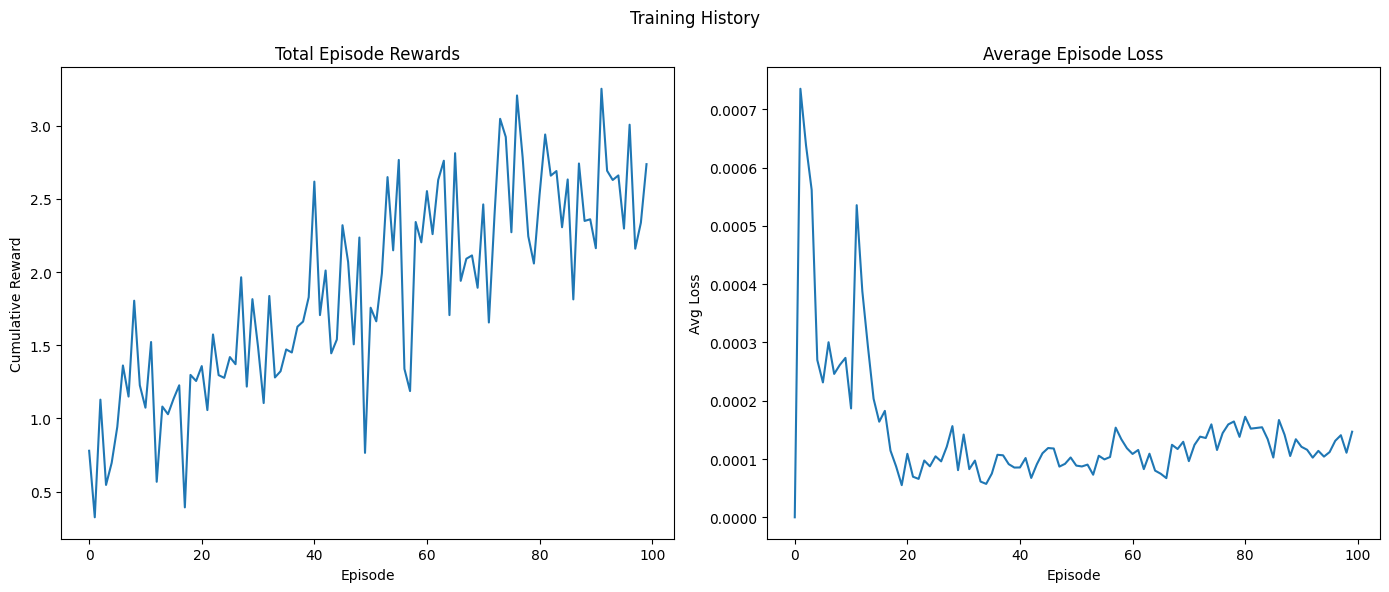

In [ ]:
visualize_results_history(training_history, test_results, gt_image, best_mask_train)


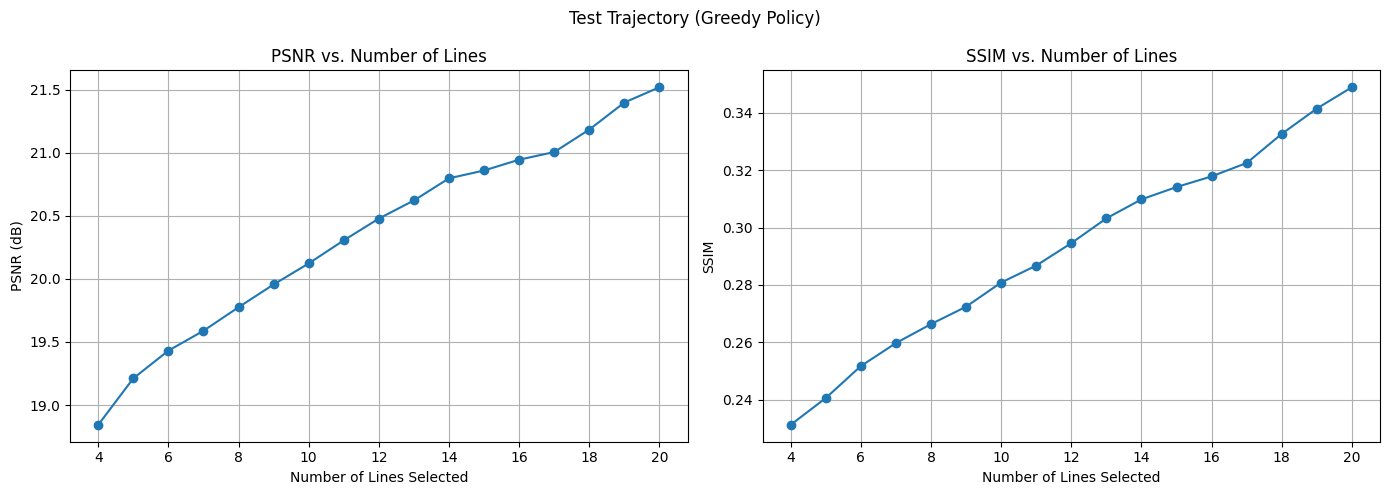

In [ ]:
visualize_results_test_trajectories(training_history, test_results, gt_image, best_mask_train)

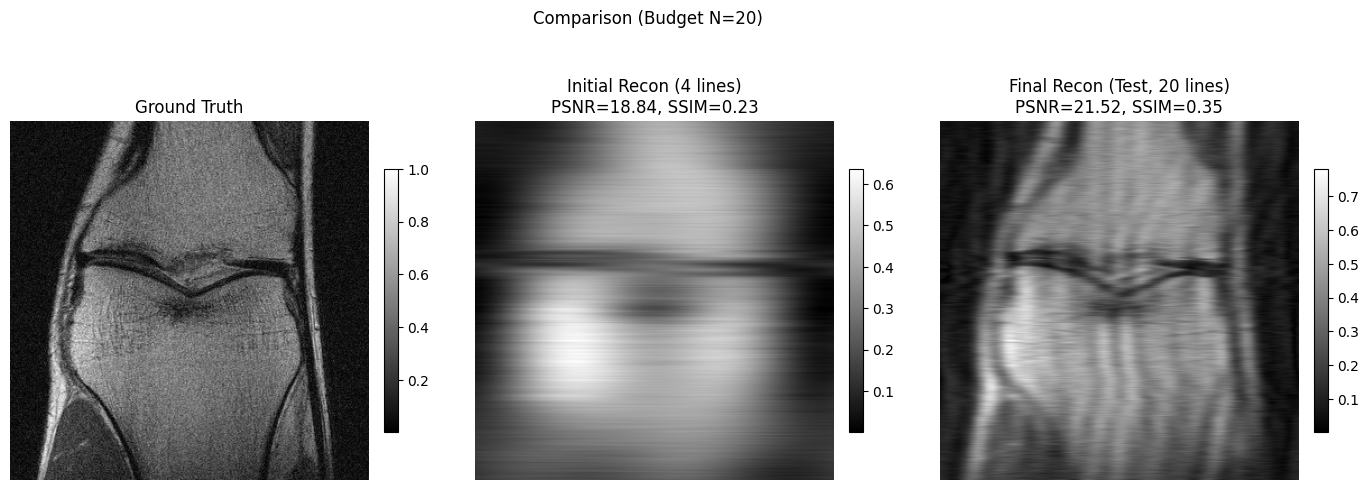

In [ ]:
visual_check_1(training_history, test_results, gt_image, best_mask_train)

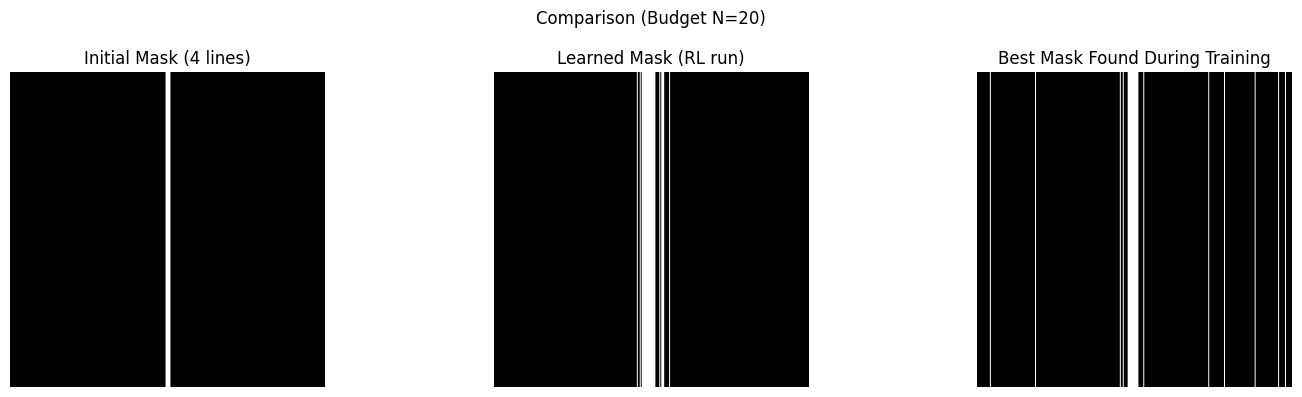


Selected line indices, first 10(in order of selection by the trained agent):
[160, 161, 158, 159, 157, 156, 148, 154, 153, 155]

Total lines selected: 20


In [ ]:
visual_check_2(test_results, best_mask_train)

print("\nSelected line indices, first 10(in order of selection by the trained agent):")
print(test_results['selected_lines_order'][:10])
print(f"\nTotal lines selected: {len(test_results['selected_lines_order'])}")

## Observations and Analysis

We observed higher PSNR and SSIM values compared to standard masks with the same number of lines. We also noted the presence of aliasing artifacts.

However, the shape of objects was reproduced relatively good with a decent amount of details.

Would enforcing a symmetry constraint, as an additional rule, improve the quality of restoration performed by an RL agent?

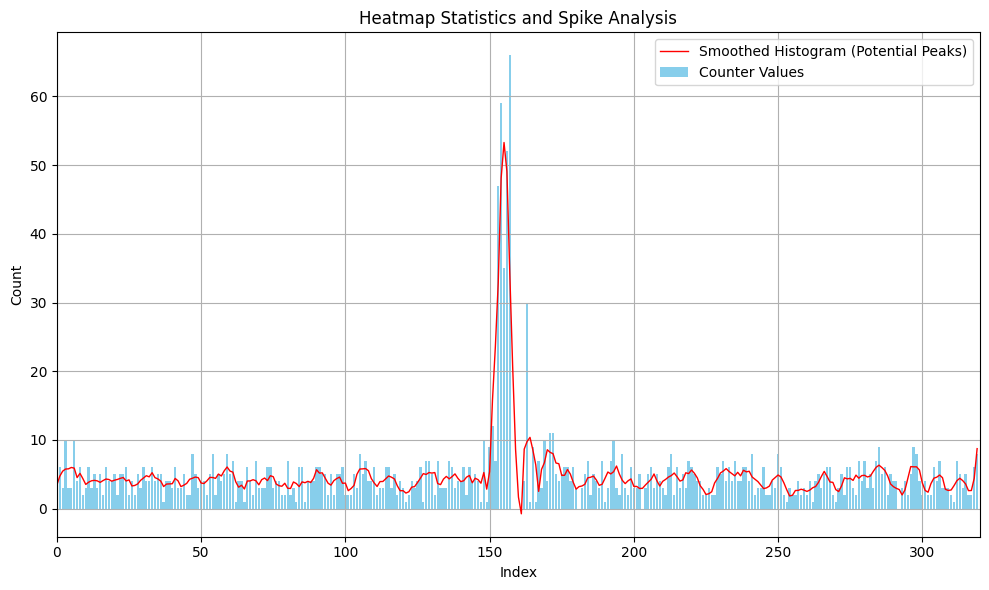

In [ ]:
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import describe

heat_map = agent.stat

smoothing_window=9        # The window size for Savitzky-Golay smoothing.  Must be odd.
polyorder=3                # The polynomial order for Savitzky-Golay smoothing.

smoothed_histogram = savgol_filter(heat_map, smoothing_window, polyorder)

plt.figure(figsize=(10, 6))
plt.bar(range(320), heat_map, color='skyblue', label='Counter Values')  # Histogram
plt.plot(range(320), smoothed_histogram, color='red', linewidth=1, label='Smoothed Histogram (Potential Peaks)')


plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Heatmap Statistics and Spike Analysis')
plt.legend()
plt.grid(True)
plt.xlim(0, 320)  # Ensure x-axis covers the full array length
plt.tight_layout()  # Prevent labels from overlapping
plt.show()

### Testing three different sampling masks on the whole validation dataset

In [ ]:
from typing import List
import pandas as pd

def analyze_restorations(val_dir, masks: List[Mask]):  # Added mask_names

  """
  Analyzes restoration quality using different masks on images in the validation directory.

  Args:
    val_dir: Path to the directory containing HDF5 image files.
    masks: A list of Mask objects

  Returns:
    A pandas DataFrame containing PSNR and SSIM statistics for each image and mask.
  """

  results = []
  image_files = [f for f in os.listdir(val_dir) if f.endswith('.h5')]

  with tqdm(total=len(image_files), desc=f"analysing") as pbar:
    for image_file in image_files:
      image_path = os.path.join(val_dir, image_file)
      ground_truth_image = load_sample_image(image_path)
      full_kspace = image_to_kspace(ground_truth_image)

      for mask in masks:
        current_reconstruction = apply_mask_and_reconstruct(full_kspace, mask.data)
        psnr, ssim = calculate_metrics(ground_truth_image, current_reconstruction)

        results.append({
            'Image File': image_file,
            'Mask': mask.name,  # Store the mask name
            'Mask Lines': mask.size,
            'PSNR': psnr,
            'SSIM': ssim
        })
      pbar.update(1)

  df = pd.DataFrame(results)
  return df

In [ ]:
rl_sample_mask = define_mask(dir_name='./', mask_name='best_mask_train')
masks = [reg_sample_mask, rnd_sample_mask, rl_sample_mask]
df = analyze_restorations(f'{data_path}/val/h5', masks)
print("complete")

<class 'numpy.float32'>


analysing: 100%|██████████| 500/500 [00:13<00:00, 38.36it/s]

complete


In [ ]:
df.groupby('Mask')[['PSNR', 'SSIM']].agg(['mean', 'std'])

PSNR                SSIM          
                                 mean       std      mean       std
Mask                                                               
best_mask_train             22.251269  1.711709  0.460380  0.096655
fMRI_Ran_AF16_CF0.02_PE320  19.874086  1.741755  0.414085  0.090416
fMRI_Reg_AF16_CF0.02_PE320  19.748719  1.737870  0.411653  0.090685

### Repeating experiments with N=32 lines

In [ ]:
rnd_sample_mask = define_mask(dir_name='./', mask_name='fMRI_Ran_AF8_CF0.04_PE320')
reg_sample_mask = define_mask(dir_name='./', mask_name='fMRI_Reg_AF8_CF0.04_PE320')
print(reg_sample_mask.size)

BUDGET_N = 32
agent_2 = DQNAgent(
    img_h=IMG_SIZE,
    img_w=IMG_SIZE,
    n_actions=N_LINES_TOTAL,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    lr=LR,
    target_update_freq=TARGET_UPDATE_FREQ,
    eps_start=EPS_START,
    eps_end=EPS_END,
    eps_decay=EPS_DECAY
)
training_history, best_mask_train, gt_image, kspace_full = train(ground_truth_image=sample_image, agent=agent_2)


<class 'numpy.float32'>
<class 'numpy.float32'>
320
image shape: (320, 320), dtype: float32, range: [0.00020751735428348184, 1.000012993812561]

--- Starting Training for 100 episodes ---
Budget N=32, Initial K=4
Reward based on: SSIM + PSNR improvement (Scaled by 1.0)


Training: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s, psnr=21.4, ssim=0.382, loss=0.000147, best_psnr=21.9]


--- Training Finished in 93.44 seconds ---
Best PSNR achieved during training: 21.9316
Model saved to dqn_mri_model.pth


In [ ]:
rl_sample_mask = define_mask(dir_name='./', mask_name='best_mask_train')
masks = [reg_sample_mask, rnd_sample_mask, rl_sample_mask]
df_2 = analyze_restorations(f'{data_path}/val/h5', masks)
print("complete")

<class 'numpy.float32'>


analysing: 100%|██████████| 500/500 [00:13<00:00, 36.17it/s]

complete


In [ ]:
df_2.groupby('Mask')[['PSNR', 'SSIM']].agg(['mean', 'std'])

PSNR                SSIM          
                                mean       std      mean       std
Mask                                                              
best_mask_train            24.093863  1.820787  0.527592  0.089501
fMRI_Ran_AF8_CF0.04_PE320  22.559890  1.814797  0.482409  0.091788
fMRI_Reg_AF8_CF0.04_PE320  22.627993  1.805400  0.498677  0.087624

## Observations and Conclusion

We have designed a new mask applying RL approach using one sample file for training.

The approach in current implementation is obviously poorly scalable. Howerver, analysis on 500 images in `val/h5` folder has shown that our suboptimal mask is better than standard masks built on some basic generic principles. Note, we did not include many assumptions into RL algorithm; nevertheless the agent was able to find a decent solution in a fully autonomous way.

Looking ahead, potential improvements to the RL agent include incorporating explicit rules and constraints into the mask generation process, such as enforcing symmetry or adhering to specific geometric properties.
